<a href="https://www.kaggle.com/code/carolinariddick/data-scraping-from-understat-statsbomb?scriptVersionId=274318945" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## _Data Scraping from Understat & Statsbomb_

#### This notebook is about data scraping from Understat & statsbomb

*Some of the steps include*
1. **Installing and importing libraries**
2. **Accesing different futbol data providers**
3. **Data manipulation (numpy, pandas, processing, creting new data frames)**
4. **Data cleaning and preprocessing**
5. **Data visualziation**
    1. **Team pass map**
    2. **Player pass map**

## Install libraries

In [17]:
!pip install statsbombpy --quiet
!pip install mplsoccer --quiet
!pip install highlight_text --quiet

## Import libraries

In [26]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import Pitch
from mplsoccer import VerticalPitch,Pitch
import requests
from bs4 import BeautifulSoup
import json
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns

## We can acces the data in different wayd and with many providers:
### 1. Undertstat
### 2. Statsbomb

## _Data Scraping from Understat_

In [19]:
baseUrl = 'https://understat.com/match/'
match = str(input('Please enter the matdh id: ')) # 22514
url = baseUrl + match
print(url)

Please enter the matdh id:  22514


https://understat.com/match/22514


In [22]:
response = requests.get(url)
soup = BeautifulSoup(response.content,'lxml')
scripts = soup.find_all('script')

# scripts

#### As we can see, the shots data (shots on goal) are the first data that appear.
#### This means that, if we want to work only with data related to shots on goal, we need to use the number 1.
#### After each word var, there is a different dataset, so if you want to work with another one, you just need to specify its corresponding number.

In [24]:
dataShots = scripts[1].string
# dataShots

### What is data Scraping? How we can access StatsBombs free database of competitions and matches ?


#### *Data scraping, also known as web scraping, is a technique that allows extracting information from websites. This information can be saved in files or spreadsheets.*


We have to call Statsbomb API

In [27]:
# Lets convert this to JSON
# We will now delete the symbols to get only the JSON data

indStart = dataShots.index("('")+2
indEnd = dataShots.index("')")

jsonData = dataShots[indStart:indEnd]
jsonData = jsonData.encode('utf8').decode('unicode_escape')

# We will now convert the string into json
data = json.loads(jsonData)
# data

#### For this example, we only need ‘x’ and ‘y’, which are the coordinates required to ensure that when we process these data, they appear at the correct spot on the pitch. Additionally, we need xG (expected goals for each shot) and ‘h_team’ (home team).

#### But if you wanted more, you would just need to add what I’ve written below, such as ‘shotType’ if you're interested in knowing what type of shot it was, or ‘situation’ if you want to see when in the game the shot occurred.

In [28]:
x = []
y = []
xg = []
team = []

# Data from visitor team
data_away = data['a']

# Data from the local team
data_home = data['h']

for index in range(len(data_home)):
    for key in data_home[index]:
        if key =='X' :
            x.append(data_home[index][key])
        if key == 'Y' :
            y.append(data_home[index][key])
        if key == 'xG' :
            xg.append(data_home[index][key])
        if key == 'h_team' :
            team.append(data_home[index][key])

### Now, we want the processed data to appear with the columns we need (x, y, xG, and h_team) so we can view them in an organised way. We add the following:

In [30]:
col_name = ['x', 'y', 'xg', 'team']
df = pd.DataFrame([x,y,xg,team], index=col_name)
df = df.T
df

,x,y,xg,team
0,0.725999984741211,0.5020000076293946,0.013946167193353176,Sassuolo
1,0.775,0.36,0.029432695358991623,Sassuolo
2,0.9619999694824218,0.519000015258789,0.13621848821640015,Sassuolo
3,0.7190000152587891,0.475,0.01597519963979721,Sassuolo
4,0.84,0.6830000305175781,0.04199923574924469,Sassuolo


### What have we achieved with this?

Well, for example, we can now see the xG (expected goals) of each shot made by Sassuolo.
This is just an example using shot data, but as we explained earlier, you can try it with other types of data as well — just make sure to replace xG with the variable corresponding to the data you need, such as key passes if you’re looking for passing data, or many other examples you can explore.

## _Data Scraping from StatsBomb_

In [97]:
#call statsbombpy API to get all free competitions
free_comps = sb.competitions()

# print a list of free competitions
free_comps.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-09-28T20:46:38.893391,2025-07-06T04:26:07.636270,2025-07-06T04:26:07.636270,2024-09-28T20:46:38.893391
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-09-28T01:57:35.846538,None,None,2024-09-28T01:57:35.846538
3,16,4,Europe,Champions League,male,False,False,2018/2019,2025-05-08T15:10:50.835274,2021-06-13T16:17:31.694,None,2025-05-08T15:10:50.835274
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [85]:
# Call the statsbombpy API to get a list of matches for a given competition
# Europe - UEFA Euro
europe_UEFA = sb.matches(competition_id=55, season_id=282)
europe_UEFA.head(4)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,...,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,...,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,...,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,...,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2


### Call specific Match

In [86]:
game_events_df = sb.events(match_id=3943043)
game_events_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Spain,772,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",England,768,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,England,768,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain,772,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,England,768,00:00:00.000,Half Start,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,England,768,00:22:42.415,Shield,True
3308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",England,768,00:24:58.861,Tactical Shift,NaN
3309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 41212, 'lineup': [{'player': {'i...",England,768,00:44:20.041,Tactical Shift,NaN
3310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Spain,772,00:44:54.242,Tactical Shift,NaN


## Explore dataset 

In [87]:
game_events_df.columns

Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'block_save_block',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'injury_stoppage_in_chain',
       'interception_outcome', 'location', 'match_id', 'minute', 'off_camera',
       'out', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_end_location',
       'pass_goal_assist

### Using the command df.columns we can get a list of all the columns in the dataset. 

1. type: Refers to the type of action (e.g., passes, shots)
2. shot_statsbomb_xg: Expected goal values
3. team: Identifies the home and away teams
4. player: Lists all players, both home and away
5. location: Provides the x and y coordinates for events
6. pass_assisted_shot_id: Represents a "key pass" (an assist leading to a shot)


To explore a specific column in more detail, we can use the `unique` command.
Let's find all the players who played in the final by using the following command

In [88]:
# List of all players
game_events_df.player.unique()

array([nan, 'Kobbie Mainoo', 'Jordan Pickford', 'Unai Simón Mendibil',
       'Robin Aime Robert Le Normand', 'Daniel Carvajal Ramos',
       'Álvaro Borja Morata Martín', 'Daniel Olmo Carvajal',
       'Jude Bellingham', 'Rodrigo Hernández Cascante', 'Aymeric Laporte',
       'Luke Shaw', 'Declan Rice', 'Marc Guehi', 'Phil Foden',
       'Kyle Walker', 'Lamine Yamal Nasraoui Ebana',
       'Marc Cucurella Saseta', 'Nicholas Williams Arthuer', 'Harry Kane',
       'Bukayo Saka', 'Fabián Ruiz Peña', 'John Stones',
       'Martín Zubimendi Ibáñez', 'Cole Palmer', 'Mikel Oyarzabal Ugarte',
       'José Ignacio Fernández Iglesias', 'Ollie Watkins', 'Ivan Toney',
       'Mikel Merino Zazón'], dtype=object)

### Creating Visualization: Team Pass Map


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


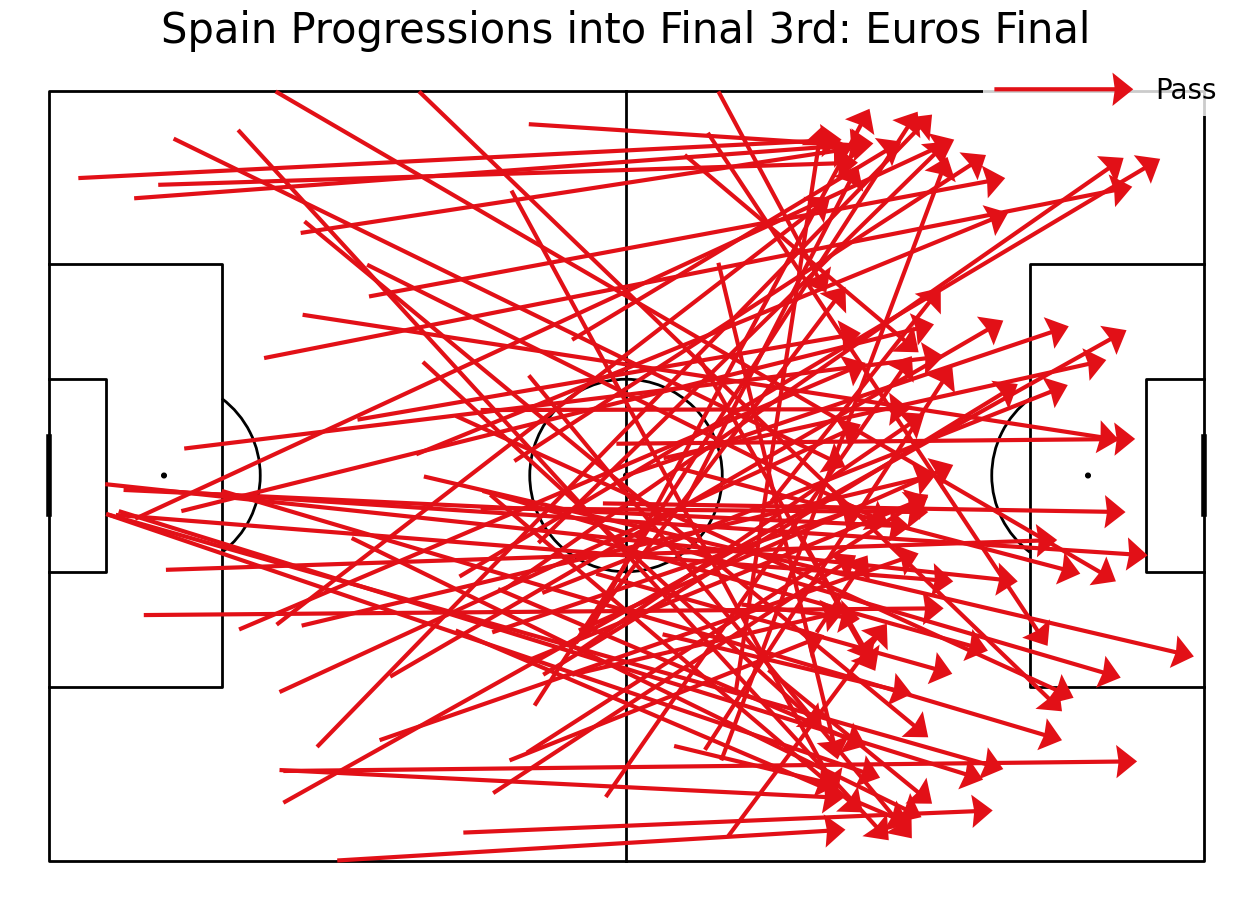

In [89]:
# Separate start and end locations from coordinates
game_events_df[['x', 'y']] = world_cup_game['location'].apply(pd.Series)
game_events_df[['pass_end_x', 'pass_end_y']] = game_events_df['pass_end_location'].apply(pd.Series)
game_events_df[['carry_end_x', 'carry_end_y']] = game_events_df['carry_end_location'].apply(pd.Series)

#create a variable for the team you want to look into
team="Spain"

#filter for only matches that the focus team played in
matches_df = europe_UEFA[(europe_UEFA['home_team'] == team)|(europe_UEFA['away_team'] == team)]

#filter for events done by the focus team
#filter by event type to get only passes
#filter for passes that started outside of the final third
#filter for passes that ended in the final third
#filter for completed passes
passes_df=game_events_df[(game_events_df.team==team)&(game_events_df.type=="Pass")&
            (game_events_df.x<80)&
            (game_events_df.pass_end_x>80)&
            (game_events_df.pass_outcome.isna())]

# Visualize for a team
pass_colour='#e21017'

# Create the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_zorder=2, line_color='black')
fig, ax = pitch.draw(figsize=(16, 11),constrained_layout=True, tight_layout=False)
fig.set_facecolor('white')

# Visualiza passes
pitch.arrows(passes_df.x, passes_df.y,
passes_df.pass_end_x, passes_df.pass_end_y, width=3,
headwidth=8, headlength=5, color=pass_colour, ax=ax, zorder=2, label = "Pass")

ax.legend(facecolor='white', handlelength=5, edgecolor='None', fontsize=20, loc='best')

# Set title
ax_title = ax.set_title(f'{team} Progressions into Final 3rd: Euros Final', fontsize=30,color='black')

## Creating Visualization: Player Pass Map


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


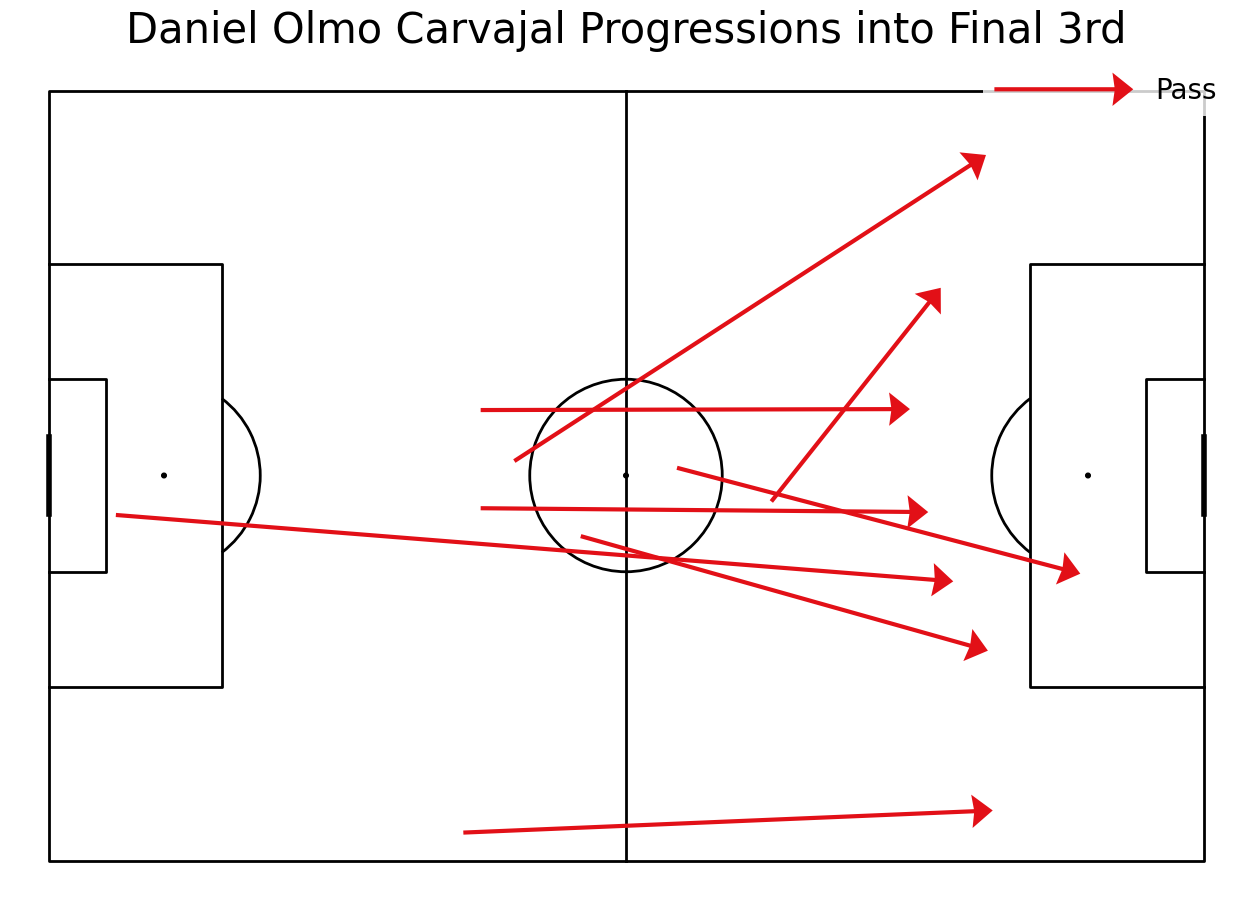

In [96]:
# Visualize for a specific player
player_name="Daniel Olmo Carvajal"

player_passes=game_events_df[(game_events_df.player==player_name)&
            (game_events_df.type=="Pass")&
            (game_events_df.x<80)&
            (game_events_df.pass_end_x>80)&
            (game_events_df.pass_outcome.isna())]

pass_colour='#e21017'

# set up the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_zorder=2, line_color='black')
fig, ax = pitch.draw(figsize=(16, 11),constrained_layout=True, tight_layout=False)
fig.set_facecolor('white')

# plot passes
pitch.arrows(player_passes.x, player_passes.y,
player_passes.pass_end_x, player_passes.pass_end_y, width=3,
headwidth=8, headlength=5, color=pass_colour, ax=ax, zorder=2, label = "Pass")

# plot legend
ax.legend(facecolor='white', handlelength=5, edgecolor='None', fontsize=20, loc='best')

ax_title = ax.set_title(f'{player_name} Progressions into Final 3rd', fontsize=30,color='black')